# Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ for DESIJ1624+0129

**Author(s)**: Ahmad Al - Imtiaz, S M Rafee Adnan, Sulyman Hossain, Anowar Shajib <br>
**Acknowledgement**: Mamunur Rashid

In [43]:
!pip install photutils

## Import Libraries

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.cosmology import FlatLambdaCDM
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

## Load Data

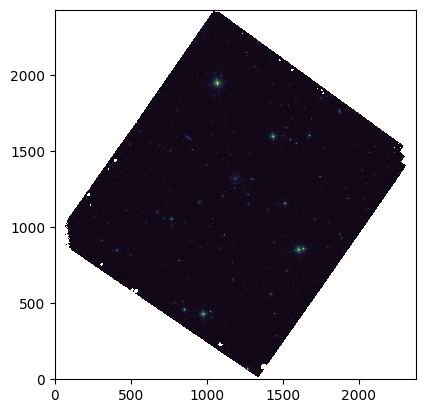

In [45]:
data, header = fits.getdata("/kaggle/input/fits-file/DESIJ16240129_F140W_drz_sci.fits", header=True)
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

/tmp/ipykernel_33/3998831433.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


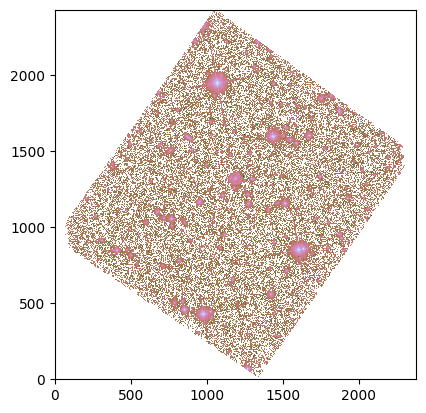

In [46]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture Photometry and Plotting

/tmp/ipykernel_33/1995947988.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


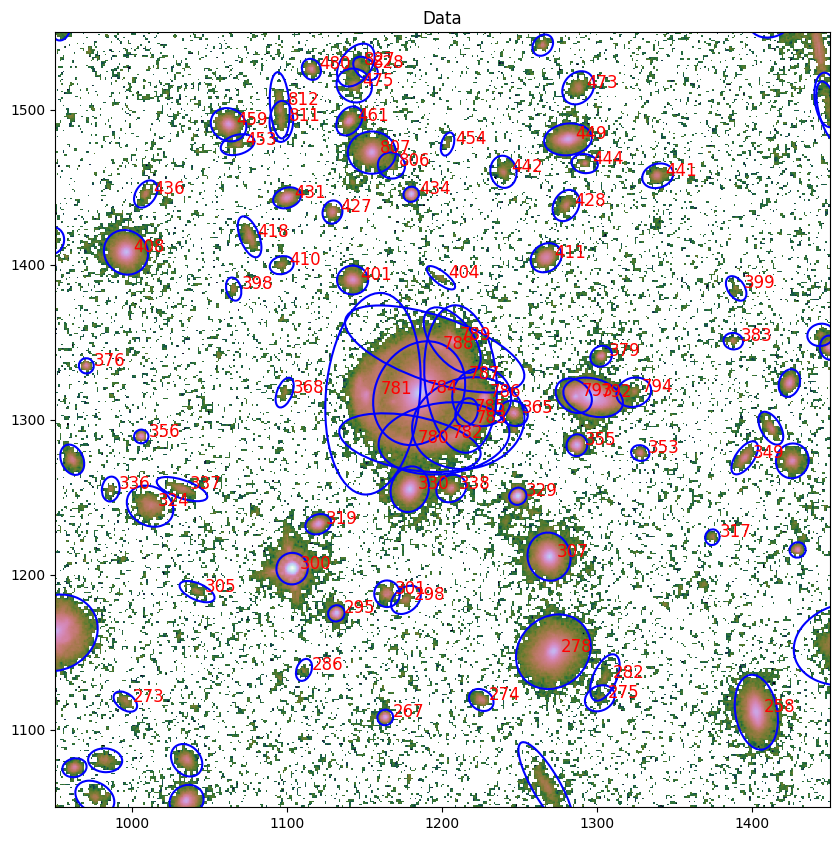

In [47]:
# Background subtraction
bkg_subtracted_data = data - bkg.background

# Source detection and segmentation
threshold = 3 * bkg.background_rms
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=8,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

# Source catalog creation
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)

# Plotting
norm = simple_norm(data, "sqrt")
fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

# Plot Kron apertures and label nearby sources
cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[784]) < 220
        and np.abs(cat.ycentroid[i] - cat.ycentroid[784]) < 220
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

# Set axis limits
set_x_lim1, set_x_lim2 = 950, 1450
set_y_lim1, set_y_lim2 = 1050, 1550

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# Hide text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

# Show the plot
plt.show()

## Identify the central deflector's ID

/tmp/ipykernel_33/2465678002.py:10: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


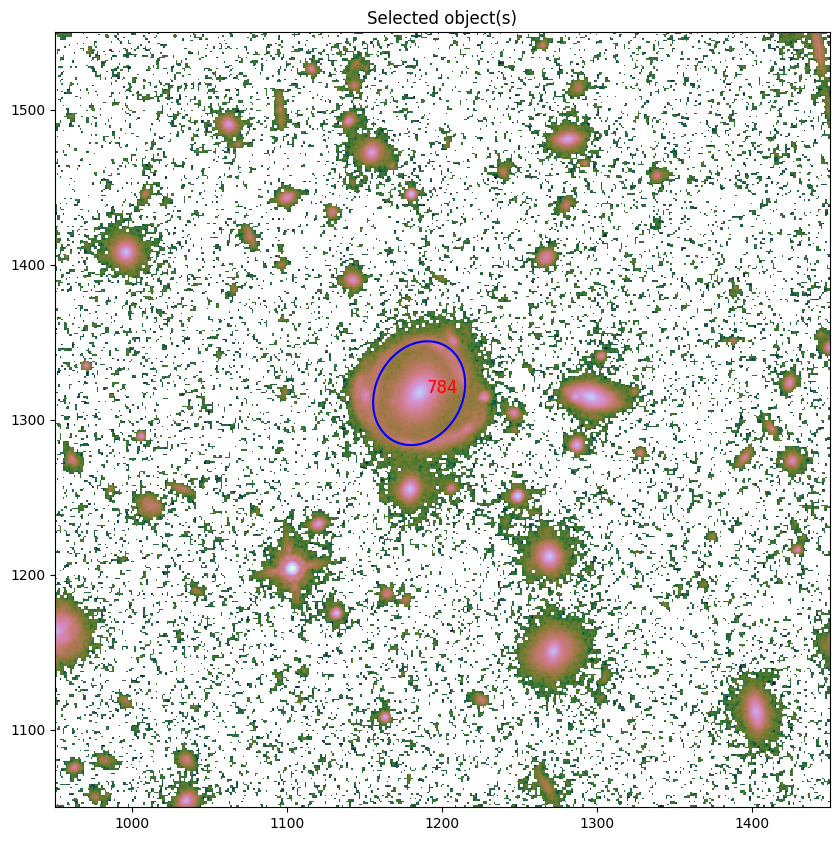

In [48]:
# Defining a function for labeling only selected objects
def label_selected_objects(selected_ids):
    # Background subtraction
    data - bkg.background

    # Plotting
    simple_norm(data, "sqrt")
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
    ax1.imshow(
        np.log10(data - bkg.background),
        origin="lower",
        cmap="cubehelix",
        vmin=-4,
        vmax=2,
    )
    ax1.set_title("Selected object(s)")

    # Plot Kron apertures and label selected objects
    for obj_id in selected_ids:
        labels = [obj_id + 1]
        cat_subset = cat.get_labels(labels)
        cat_subset.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

        ax1.text(
            cat.xcentroid[obj_id] + 5,
            cat.ycentroid[obj_id],
            f"{obj_id}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )

    # Set axis limits
    ax1.set_xlim(set_x_lim1, set_x_lim2)
    ax1.set_ylim(set_y_lim1, set_y_lim2)

    # Hide text outside of the axes
    ax1.set_clip_on(True)
    ax1.set_clip_box(ax1.bbox)

    # Show the plot
    plt.show()


# Guessing the lens galaxy
id_central = 784

# Calling the function label id_central
label_selected_objects([id_central])

In [49]:
# optional format
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating A List of Neighboring Galaxies

In [50]:
# All close galaxies
x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 20 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 20 arcsecond radius: 78


In [51]:
# Close galaxies excluding sources lower than 1% of the central deflector
x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 20 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 20 arcsecond radius: 50


## Pixels to Megaparsec unit

In [52]:
def distance_parsec(pixel_distance):
    """Convert distance from unit of pixels into parsec unit.

    :param pixel_distance: distance in unit of pixels

    :return: distance in parsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert the pixel scale from degrees to radians
    pix_scale_radian = pix_scale_deg * np.pi / 180
    
    # Angles in radians
    angles_radian = pixel_distance * pix_scale_radian
    
    # Define cosmological parameters
    H0 = 70   # Hubble constant in km/s/Mpc
    Om0 = 0.3 # Matter density parameter
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

    # Define the redshifts at which you want to compute the angular diameter distance
    z = 0.786
    
    # Compute the angular diameter distance
    angular_diameter_distance = cosmo.angular_diameter_distance(z)
    
    # Calculate the physical distance
    physical_distances_mpc = angular_diameter_distance * angles_radian 

    return physical_distances_mpc

## Identify the unwanted objects

/tmp/ipykernel_33/2465678002.py:10: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


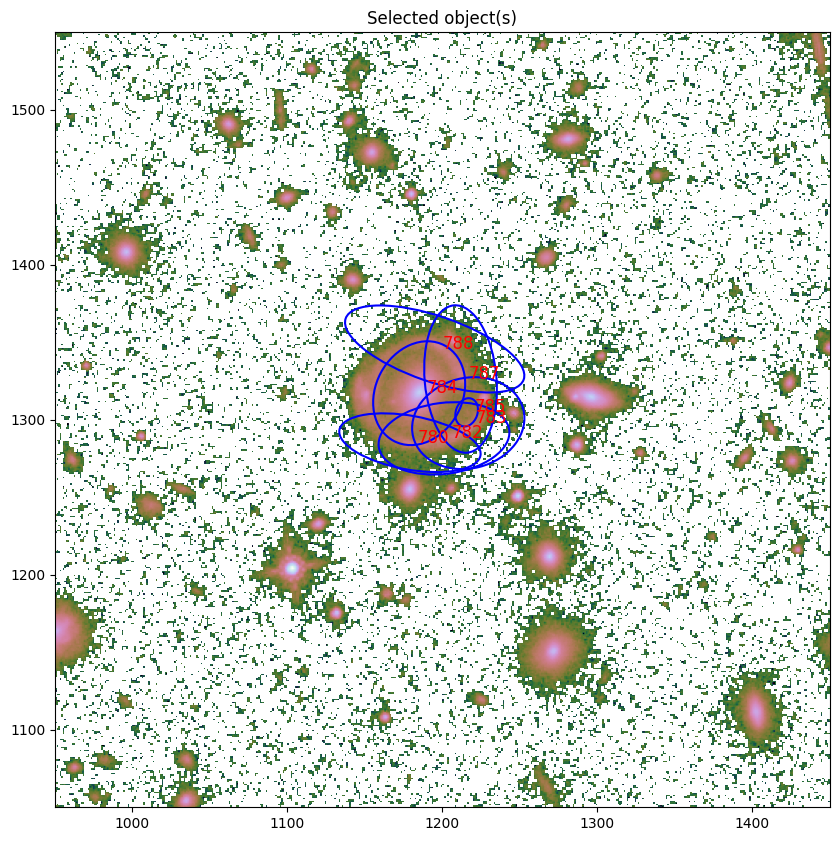

In [53]:
selected_object_ids = [780, 782, 783, 784, 785, 787, 788]
label_selected_objects(selected_object_ids)

## Removing the unwanted objects from the neighboring galaxy list

In [54]:
# All close galaxies
remove_list = [
    300, #star
    780, # part of the arc
    782, # part of the arc
    783, # part of the arc
    784, # central deflector
    785, # part of the arc
    787, # part of the arc
    788, # part of the arc
    781 # part of the arc 
]
df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(megaparsec)"] = distance_parsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(megaparsec)        Flux  Axis Ratio
789         40.320043              0.024072   46.461823    0.531966
786         40.409187              0.024125   44.067658    0.983632
330         62.243924              0.037161  135.550639    0.816725
365         62.403992              0.037257   18.378569    0.847740
338         64.900083              0.038747   11.542111    0.841493
404         75.783444              0.045244    1.782823    0.357990
401         84.677457              0.050554   32.432618    0.925928
368         86.771803              0.051805    2.204721    0.486271
329         92.054059              0.054958   86.568620    0.936359
793         99.745411              0.059550   64.110257    0.777195
319        106.709642              0.063708   32.610480    0.732076
355        107.159163              0.063976   47.421914    0.935328
792        112.267539              0.067026  378.351342    0.610515
411        119.774584              0.071508   27

In [55]:
# Excluding galaxies lower than 1% of the central deflector
remove_list_1 = [
    300, #star
    780, # part of the arc
    782, # part of the arc
    783, # part of the arc
    784, # central deflector
    # 785, # part of the arc
    787, # part of the arc
    788, # part of the arc
    781 # part of the arc
]

df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})
df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(megaparsec)"] = distance_parsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratioe"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(megaparsec)        Flux  Axis Ratioe
789         40.320043              0.024072   46.461823     0.531966
786         40.409187              0.024125   44.067658     0.983632
330         62.243924              0.037161  135.550639     0.816725
365         62.403992              0.037257   18.378569     0.847740
338         64.900083              0.038747   11.542111     0.841493
401         84.677457              0.050554   32.432618     0.925928
329         92.054059              0.054958   86.568620     0.936359
793         99.745411              0.059550   64.110257     0.777195
319        106.709642              0.063708   32.610480     0.732076
355        107.159163              0.063976   47.421914     0.935328
792        112.267539              0.067026  378.351342     0.610515
411        119.774584              0.071508   27.710273     0.823559
379        119.804210              0.071526    9.046629     0.868600
434        128.422125             

## Calculating $\Sigma_{10}$, $\Sigma_{10,\text{flux selected}}$ , $\Sigma_{20}$, $\Sigma_{20,\text{flux selected}}$ and the corresponding radii

## Method A

In [56]:
# For all sources
R_10_all = df_all_20.iloc[8, df_all_20.columns.get_loc("Distance(megaparsec)")] ## Change
R_20_all = df_all_20.iloc[18, df_all_20.columns.get_loc("Distance(megaparsec)")] ## Change
Sigma_10_allA = 10 / (np.pi * R_10_all**2)
Sigma_20_allA = 20 / (np.pi * R_20_all**2)

# Excluding dim sources
R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(megaparsec)")] ## Change
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(megaparsec)")] ## Change
Sigma_10_1A = 10 / (np.pi * R_10_1**2)
Sigma_20_1A = 20 / (np.pi * R_20_1**2)


print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_allA)
print("Sigma 20:", Sigma_20_allA)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1A)
print("Sigma 20:", Sigma_20_1A)


FOR All SOURCES
R 10: 0.05495823470826196
R 20: 0.07824245431136323
Sigma 10: 1053.8640220687269
Sigma 20: 1039.9086556572079

EXCLUDING DIM SOURCES
R 10: 0.06397630370490483
R 20: 0.09084707516873453
Sigma 10: 777.6995326278923
Sigma 20: 771.3619704445714


## Method B

In [57]:
weighted_flux_10_all = np.sum(df_all_20["Flux"][0:9] / np.max(df_all_20["Flux"][0:9]))
weighted_flux_20_all = np.sum(df_all_20["Flux"][0:19] / np.max(df_all_20["Flux"][0:19]))
Sigma_10_allB = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allB = weighted_flux_20_all / (np.pi * R_20_all**2)


weighted_flux_10_1 = np.sum(df_1_20["Flux"][0:10] / np.max(df_1_20["Flux"][0:10]))
weighted_flux_20_1 = np.sum(df_1_20["Flux"][0:20] / np.max(df_1_20["Flux"][0:20]))
Sigma_10_1B = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1B = weighted_flux_20_1 / (np.pi * R_20_1**2)

print("")
print("Considering Light Flux")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allB)
print("Sigma 20_updated:", Sigma_20_allB)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1B)
print("Sigma 20_updated:", Sigma_20_1B)


Considering Light Flux
FOR All SOURCES
R 10: 0.05495823470826196
R 20: 0.07824245431136323
Sigma 10_updated: 294.6526025964265
Sigma 20_updated: 137.2387074499422

EXCLUDING DIM SOURCES
R 10: 0.06397630370490483
R 20: 0.09084707516873453
Sigma 10_updated: 297.8507403382697
Sigma 20_updated: 128.81161223372325


## Method C

In [58]:
flux_10_all = []
flux_20_all = []
flux_10_1 = []
flux_20_1 = []

# for all sources
for i in range(19):
    flux_all = df_all_20["Flux"][i:i+1] / df_all_20["Distance(megaparsec)"][i:i+1]
    
    if i < 9:
        flux_10_all.append(flux_all)
        flux_20_all.append(flux_all)
        
    elif 8 < i < 19:
        flux_20_all.append(flux_all)
        
weighted_flux_10_all = np.sum(flux_10_all / np.max(flux_10_all))
weighted_flux_20_all = np.sum(flux_20_all / np.max(flux_20_all))
Sigma_10_allC = weighted_flux_10_all  / (np.pi * R_10_all**2)
Sigma_20_allC = weighted_flux_20_all / (np.pi * R_20_all**2)

# excluding dim sources
for i in range(20):
    flux_1 = df_1_20["Flux"][i:i+1] / df_1_20["Distance(megaparsec)"][i:i+1]
    
    if i < 10:
        flux_10_1.append(flux_1)
        flux_20_1.append(flux_1)
        
    elif 9 < i < 20:
        flux_20_1.append(flux_1)
        
weighted_flux_10_1 = np.sum(flux_10_1 / np.max(flux_10_1))
weighted_flux_20_1 = np.sum(flux_20_1 / np.max(flux_20_1))
Sigma_10_1C = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1C = weighted_flux_20_1 / (np.pi * R_20_1**2)

print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allC)
print("Sigma 20_updated:", Sigma_20_allC)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1C)
print("Sigma 20_updated:", Sigma_20_1C)


Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.05495823470826196
R 20: 0.07824245431136323
Sigma 10_updated: 303.1951476692298
Sigma 20_updated: 182.09525984938313

EXCLUDING DIM SOURCES
R 10: 0.06397630370490483
R 20: 0.09084707516873453
Sigma 10_updated: 271.66571755787
Sigma 20_updated: 156.56683937987773


## Method D

In [59]:
# Initialize flux variables
flux_10_all = []
flux_20_all = []
flux_10_1 = []
flux_20_1 = []

# Define a short radius
pixel_distance = 125 # for 10 arcseconds
s = distance_parsec(pixel_distance).value

# Process both dataframes
for i in range(20):
    distance_all = df_all_20["Distance(megaparsec)"].iloc[i]
    flux_all = df_all_20["Flux"].iloc[i]
    distance_1 = df_1_20["Distance(megaparsec)"].iloc[i]
    flux_1 = df_1_20["Flux"].iloc[i]
    
    # Processing for df_all_20
    if i < 9:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_10_all.append(flux_contrib_all)
        flux_20_all.append(flux_contrib_all)
        
    elif 8 < i < 19:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_20_all.append(flux_contrib_all)
    
    # Processing for df_1_20
    if i < 10:
        
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_10_1.append(flux_contrib_1)
        flux_20_1.append(flux_contrib_1)
        
    elif 9 < i < 20:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_20_1.append(flux_contrib_1)

weighted_flux_10_all = np.sum(flux_10_all / np.max(flux_10_all))
weighted_flux_20_all = np.sum(flux_20_all / np.max(flux_20_all))
Sigma_10_allD = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allD = weighted_flux_20_all / (np.pi * R_20_all**2)

weighted_flux_10_1 = np.sum(flux_10_1 / np.max(flux_10_1))
weighted_flux_20_1 = np.sum(flux_20_1 / np.max(flux_20_1))
Sigma_10_1D = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1D = weighted_flux_20_1 / (np.pi * R_20_1**2)

# Print results
print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allD)
print("Sigma 20_updated:", Sigma_20_allD)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1D)
print("Sigma 20_updated:", Sigma_20_1D)



Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.05495823470826196
R 20: 0.07824245431136323
Sigma 10_updated: 294.6526025964265
Sigma 20_updated: 136.99037141337078

EXCLUDING DIM SOURCES
R 10: 0.06397630370490483
R 20: 0.09084707516873453
Sigma 10_updated: 297.8507403382697
Sigma 20_updated: 125.7734870387735


## Visualization

/tmp/ipykernel_33/432903831.py:19: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_33/432903831.py:22: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_33/432903831.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_33/432903831.py:28: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


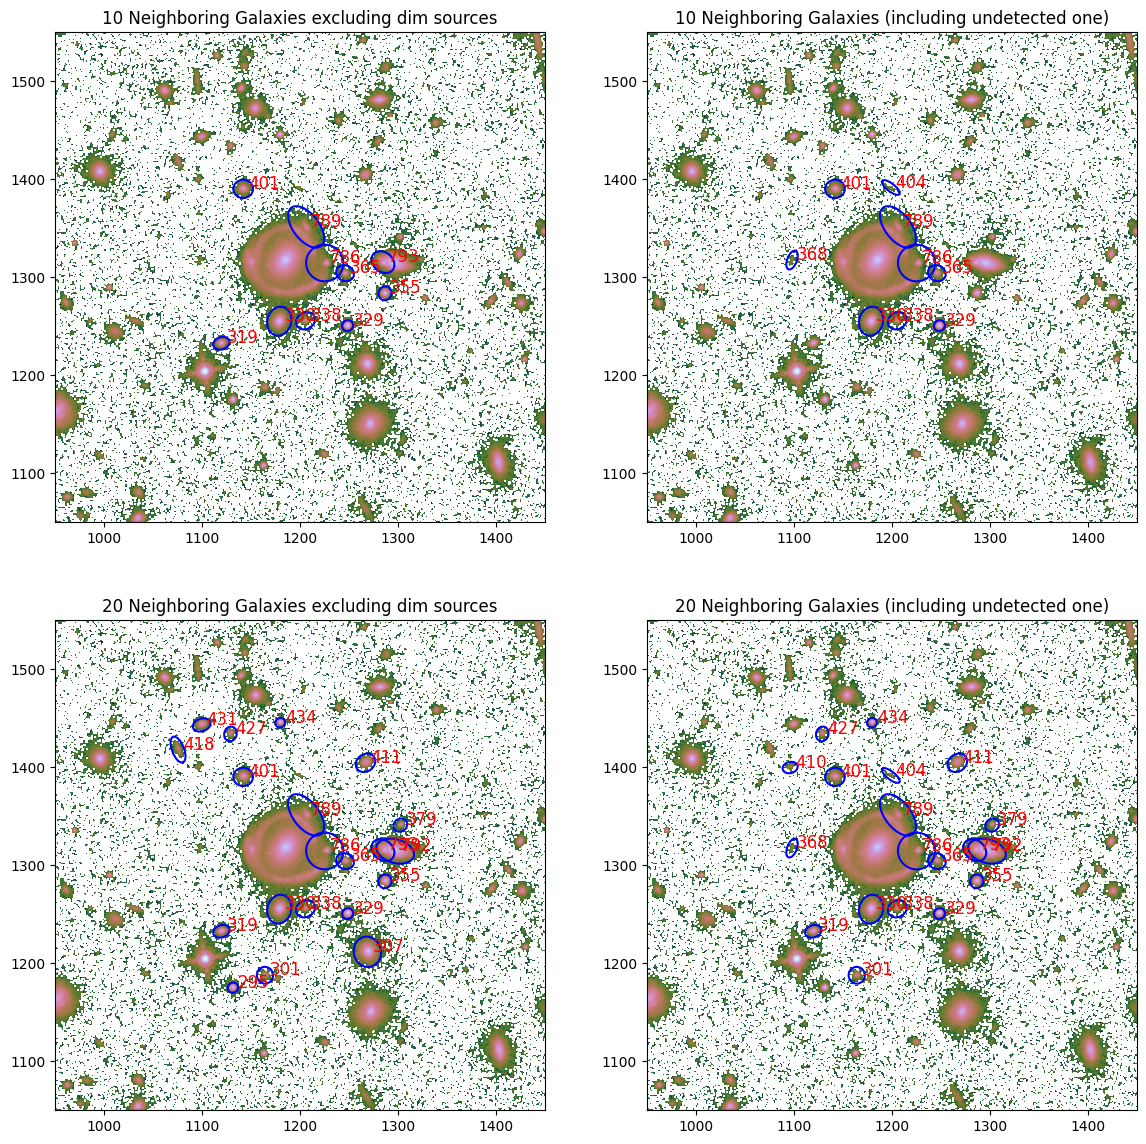

In [60]:
close_ids_all = list(df_all_20.index.values)
close_ids_all.pop(19)
close_ids_all_10 = close_ids_all[:10]
close_ids_all_10.pop(9)

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:9]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighboring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighboring Galaxies (including undetected one)")
axs[1, 0].set_title("20 Neighboring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighboring Galaxies (including undetected one)")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

## Store the results to the YAML file

In [61]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1624+0129_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10a_flux_selected": Sigma_10_1A,
    "Sigma_20a_flux_selected": Sigma_20_1A,
    "Sigma_10a": Sigma_10_allA,
    "Sigma_20a": Sigma_20_allA,
    
    "Sigma_10b_flux_selected": Sigma_10_1B,
    "Sigma_20b_flux_selected": Sigma_20_1B,
    "Sigma_10b": Sigma_10_allB,
    "Sigma_20b": Sigma_20_allB,
    
    "Sigma_10c_flux_selected": Sigma_10_1C,
    "Sigma_20c_flux_selected": Sigma_20_1C,
    "Sigma_10c": Sigma_10_allC,
    "Sigma_20c": Sigma_20_allC,
    
    "Sigma_10d_flux_selected": Sigma_10_1D,
    "Sigma_20d_flux_selected": Sigma_20_1D,
    "Sigma_10d": Sigma_10_allD,
    "Sigma_20d": Sigma_20_allD
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [62]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 16
{'Sigma_10a': 1053.8640220687269, 'Sigma_10a_flux_selected': 777.6995326278923, 'Sigma_10b': 294.6526025964265, 'Sigma_10b_flux_selected': 297.8507403382697, 'Sigma_10c': 303.1951476692298, 'Sigma_10c_flux_selected': 271.66571755787, 'Sigma_10d': 294.6526025964265, 'Sigma_10d_flux_selected': 297.8507403382697, 'Sigma_20a': 1039.9086556572079, 'Sigma_20a_flux_selected': 771.3619704445714, 'Sigma_20b': 137.2387074499422, 'Sigma_20b_flux_selected': 128.81161223372325, 'Sigma_20c': 182.09525984938313, 'Sigma_20c_flux_selected': 156.56683937987773, 'Sigma_20d': 136.99037141337078, 'Sigma_20d_flux_selected': 125.7734870387735}
